# Лабораторная работа 4: Семантическая сегментация с использованием PyTorch

## Цели работы

Цель — разработать и обучить сверточную нейронную сеть для задачи мультиклассовой семантической сегментации изображений на наборе данных [SUIM](https://www.kaggle.com/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim) с использованием PyTorch.

## Набор данных.

1. Данные содержат 8 классов. Маска сегментации имеет вид трехканального изображения с пикселями, значения которых равно либо 0, либо 255, например, (0, 0, 0), (0, 0, 255) и так далее. Помимо этого встречаются и промежуточные значения, отличные от 0 и 255. В рамках данной лабораторной работы предлагается следующее преобразование: значения маски, меньшие 128, нужно установить в 0, а значения, равные или больше 128, установить в 255.

2. Для упрощения работы рекомендуется объединить следующие классы в один:
- класс 2 - Aquatic plants and sea-grass
- класс 3 - Wrecks and ruins
- класс 5 - Reefs and invertebrates
- класс 7 - Sea-floor and rocks

##  Требования

1. Необходимо выполнить и отобразить в Jupyter следующие задачи:

	- Загрузка и проверка данных. Загрузить и предобработать данные с демонстрацией избранных изображений и соответствующих масок, чтобы подтвердить корректность загрузки и соответствие размерностей данных.
	- Реализация архитектуры сети. Разработать архитектуру нейронной сети для сегментации с использованием фреймворка PyTorch.
	- Настройка гиперпараметров обучения. Настроить параметры обучения, такие как функция ошибки, размер сети, скорость обучения и другие параметры.
	- Тестирование модели. После завершения обучения для оценки качества работы необходимо посчитать accuracy, [IoU](https://lightning.ai/docs/torchmetrics/latest/segmentation/mean_iou.html) и визуализировать [confusion matrix](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html) (с нормализацией, ```normalize='true'```).
	- Визуализация результатов. После завершения обучения построить и отобразить результаты сегментации на тестовых изображениях, сравнивая с реальными масками сегментации.

2. Выбор архитектуры:
  - Можно использовать или адаптировать известные архитектуры глубокого обучения.
  - Может быть полезным:
    - уменьшить количество параметров в нейронной сети и размер входного изображения для ускорения сходимости, предотвращения переобучения и ускорения работы нейронной сети.
    - использовать аугментацию данных и взвешенные/специализированные функции ошибки. При аугментации данных необходимо учитывать связь изображений с маской классов.
  - Использовать перенос знаний недопустимо.

In [3]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sea
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm import trange

In [4]:
classes = {
    "background": [(0, 0, 0)],
    "human_divers": [(0, 0, 1)],
    "robots": [(1, 0, 0)],
    "fish_vertebrates": [(1, 1, 0)],
    "other": [(0, 1, 0), (0, 1, 1), (1, 0, 1), (1, 1, 1)],
}

num_classes = len(classes)

In [14]:
def load_dataset(images_path, masks_path, image_size):
    images = []
    images_list_dir = sorted(os.listdir(images_path))
    for file_name in images_list_dir:
        file_path = os.path.join(images_path, file_name)
        if os.path.isfile(file_path):
            with Image.open(file_path) as image:
                resized_image = np.array(image.resize(image_size)) / 255
                images.append(resized_image)

    labels = []
    masks_list_dir = sorted(os.listdir(masks_path))
    for file_name in masks_list_dir:
        file_path = os.path.join(masks_path, file_name)
        if os.path.isfile(file_path):
            with Image.open(file_path) as mask:
                resized_mask = np.array(mask.resize(image_size)) / 255
                resized_mask = np.where(resized_mask < 0.5, 0, 1)

                masks = {class_name: np.zeros(image_size) for class_name in classes.keys()}

                for i in range(image_size[0]):
                    for j in range(image_size[1]):
                        has_class = False
                        for class_name, class_mask in classes.items():
                            if class_name == "other":
                                continue
                            if np.all(resized_mask[i, j] == class_mask, axis=-1):
                                masks[class_name][i, j] = 1
                                has_class = True
                                break
                        if not has_class:
                            masks["other"][i, j] = 1

                labels.append(np.stack(list(masks.values()), -1))

    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(np.array(images, dtype=np.float32)),
        torch.from_numpy(np.array(labels, dtype=np.float32)),
    )

    return dataset

In [15]:
image_size = (80, 80)

In [17]:
train_dataset = load_dataset("train_val/images", "train_val/masks", image_size)
test_dataset = load_dataset("TEST/images", "TEST/masks", image_size)

In [20]:
print("Размер датасета изображений (train):", train_dataset.tensors[0].shape)
print("Размер датасета масок (train):", train_dataset.tensors[1].shape)

print("Размер датасета изображений (test):", test_dataset.tensors[0].shape)
print("Размер датасета масок (test):", test_dataset.tensors[1].shape)

Размер датасета изображений (train): torch.Size([1525, 80, 80, 3])
Размер датасета масок (train): torch.Size([1525, 80, 80, 5])
Размер датасета изображений (test): torch.Size([110, 80, 80, 3])
Размер датасета масок (test): torch.Size([110, 80, 80, 5])


In [21]:
classes_colors = [[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 1, 0], [0, 1, 0]]


def plot_images_with_masks(dataset, title):
    rows = 4
    columns = 2
    fig, axes = plt.subplots(rows, columns * 2, figsize=(15, 15))
    fig.suptitle(title)

    mask_sizes = (*image_size, 3)

    for number in range(rows * columns):
        i = number // columns
        j = number % columns

        image, mask = dataset[number]

        axes[i, j * 2].imshow(image, cmap=plt.cm.binary)
        axes[i, j * 2].axis("off")
        axes[i, j * 2].set_title("Original")

        rgb_mask = np.zeros(mask_sizes)
        for class_index in range(num_classes):
            rgb_mask[mask[:, :, class_index] > 0] = classes_colors[class_index]

        axes[i, j * 2 + 1].imshow(image, cmap=plt.cm.binary)
        axes[i, j * 2 + 1].imshow(rgb_mask, alpha=0.35)
        axes[i, j * 2 + 1].axis("off")
        axes[i, j * 2 + 1].set_title("Masked")

    plt.tight_layout()
    plt.show()

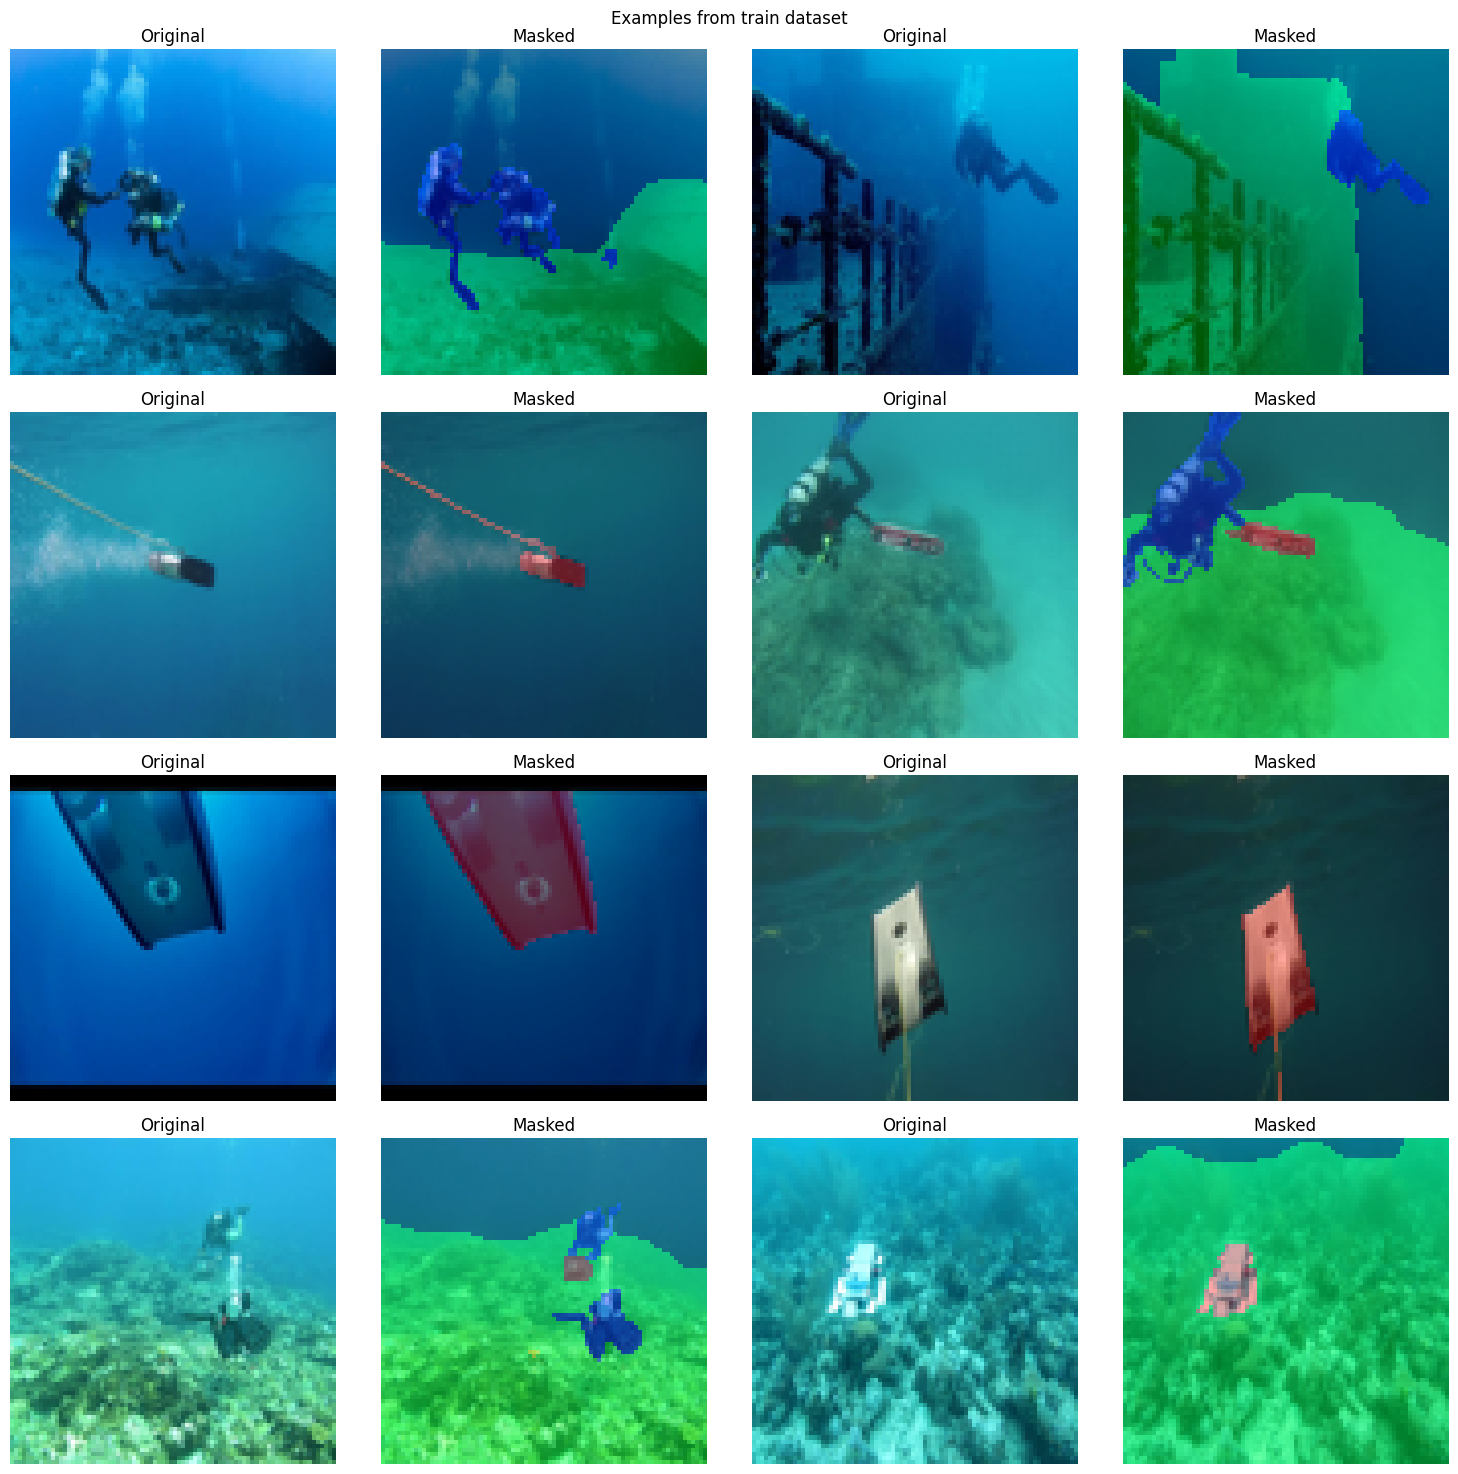

In [23]:
plot_images_with_masks(train_dataset, "Examples from train dataset")

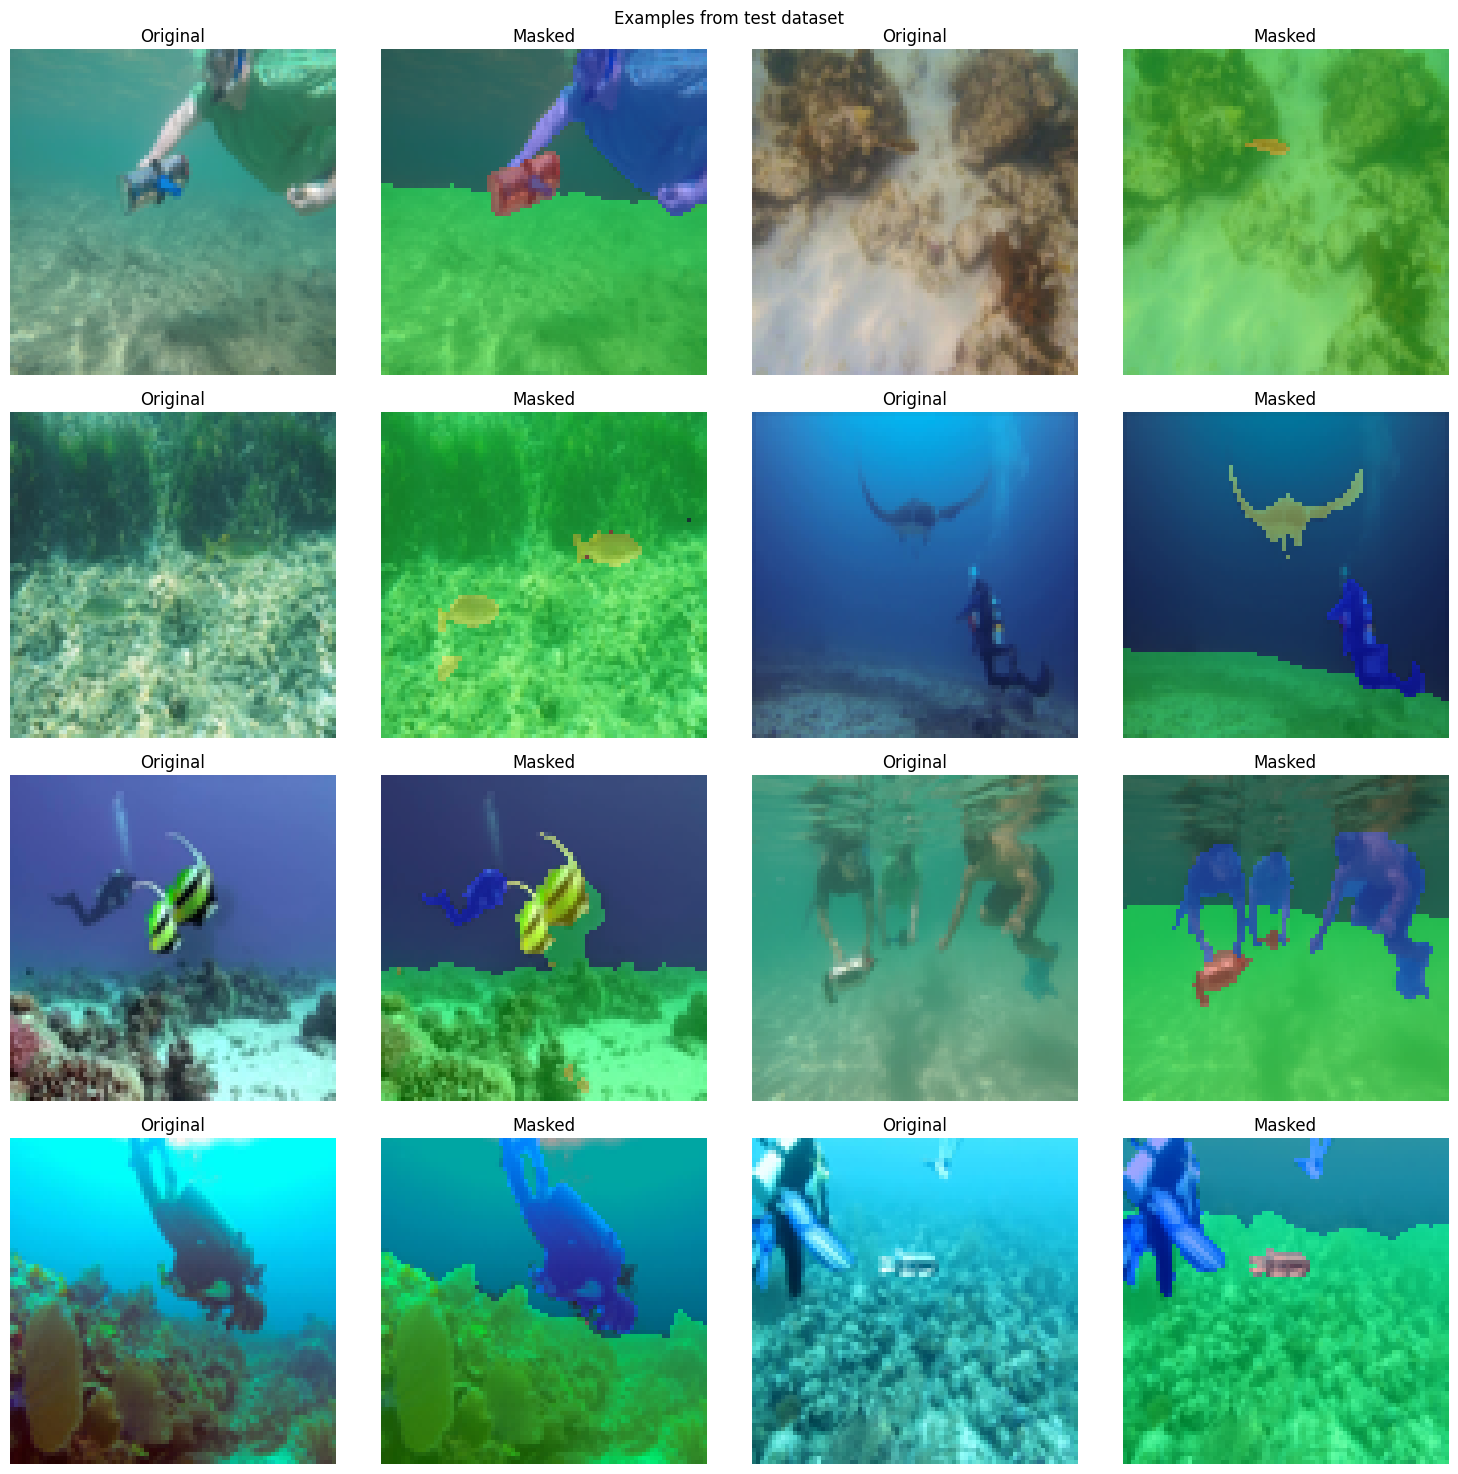

In [22]:
plot_images_with_masks(test_dataset, "Examples from test dataset")

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Обучение

In [25]:
learning_rate = 1e-3
epochs = 100
batch_size = 64

In [26]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [27]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.max_pool(x)
        return self.conv(x)


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=5):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DownSample(64, 128)
        self.down2 = DownSample(128, 256)
        self.down3 = DownSample(256, 512)
        self.down4 = DownSample(512, 1024)

        self.up1 = UpSample(1024 + 512, 512)
        self.up2 = UpSample(512 + 256, 256)
        self.up3 = UpSample(256 + 128, 128)
        self.up4 = UpSample(128 + 64, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1, bias=False)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.outc(x)

In [28]:
net = UNet(n_channels=3, n_classes=num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
summary(net, (1, 3, *image_size))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 5, 80, 80]            --
├─DoubleConv: 1-1                        [1, 64, 80, 80]           --
│    └─Sequential: 2-1                   [1, 64, 80, 80]           --
│    │    └─Conv2d: 3-1                  [1, 64, 80, 80]           1,728
│    │    └─BatchNorm2d: 3-2             [1, 64, 80, 80]           128
│    │    └─ReLU: 3-3                    [1, 64, 80, 80]           --
│    │    └─Conv2d: 3-4                  [1, 64, 80, 80]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 80, 80]           128
│    │    └─ReLU: 3-6                    [1, 64, 80, 80]           --
│    │    └─Dropout: 3-7                 [1, 64, 80, 80]           --
├─DownSample: 1-2                        [1, 128, 40, 40]          --
│    └─MaxPool2d: 2-2                    [1, 64, 40, 40]           --
│    └─DoubleConv: 2-3                   [1, 128, 40, 40]          --
│    │

In [30]:
for epoch in trange(epochs):
    net.train()
    train_loss = torch.tensor(0.0, device=device)

    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.permute(0, 3, 1, 2).to(device)
        labels_batch = labels_batch.permute(0, 3, 1, 2).to(device)

        outputs = net(images_batch)
        train_batch_loss = criterion(outputs, labels_batch)

        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()

        train_loss += train_batch_loss.detach()
    train_loss /= len(train_loader)

    print(f" Epoch: {epoch + 1}/{epochs};" f" Train loss: {train_loss.cpu().item():.4f}")

  1%|          | 1/100 [00:12<21:26, 13.00s/it]

 Epoch: 1/100; Train loss: 0.2172


  2%|▏         | 2/100 [00:26<21:16, 13.03s/it]

 Epoch: 2/100; Train loss: 0.2090


  3%|▎         | 3/100 [00:39<21:12, 13.11s/it]

 Epoch: 3/100; Train loss: 0.2002


  4%|▍         | 4/100 [00:52<21:09, 13.23s/it]

 Epoch: 4/100; Train loss: 0.1874


  5%|▌         | 5/100 [01:06<21:07, 13.35s/it]

 Epoch: 5/100; Train loss: 0.1851


  6%|▌         | 6/100 [01:19<20:56, 13.36s/it]

 Epoch: 6/100; Train loss: 0.1802


  7%|▋         | 7/100 [01:32<20:38, 13.32s/it]

 Epoch: 7/100; Train loss: 0.1804


  8%|▊         | 8/100 [01:46<20:21, 13.28s/it]

 Epoch: 8/100; Train loss: 0.1707


  9%|▉         | 9/100 [01:59<20:06, 13.26s/it]

 Epoch: 9/100; Train loss: 0.1707


 10%|█         | 10/100 [02:12<19:52, 13.25s/it]

 Epoch: 10/100; Train loss: 0.1635


 11%|█         | 11/100 [02:25<19:40, 13.27s/it]

 Epoch: 11/100; Train loss: 0.1622


 12%|█▏        | 12/100 [02:39<19:29, 13.29s/it]

 Epoch: 12/100; Train loss: 0.1529


 13%|█▎        | 13/100 [02:52<19:16, 13.29s/it]

 Epoch: 13/100; Train loss: 0.1561


 14%|█▍        | 14/100 [03:05<19:03, 13.29s/it]

 Epoch: 14/100; Train loss: 0.1543


 15%|█▌        | 15/100 [03:18<18:48, 13.28s/it]

 Epoch: 15/100; Train loss: 0.1498


 16%|█▌        | 16/100 [03:32<18:34, 13.27s/it]

 Epoch: 16/100; Train loss: 0.1523


 17%|█▋        | 17/100 [03:45<18:21, 13.27s/it]

 Epoch: 17/100; Train loss: 0.1446


 18%|█▊        | 18/100 [03:58<18:09, 13.28s/it]

 Epoch: 18/100; Train loss: 0.1495


 19%|█▉        | 19/100 [04:12<17:56, 13.29s/it]

 Epoch: 19/100; Train loss: 0.1432


 20%|██        | 20/100 [04:25<17:43, 13.29s/it]

 Epoch: 20/100; Train loss: 0.1335


 21%|██        | 21/100 [04:38<17:29, 13.28s/it]

 Epoch: 21/100; Train loss: 0.1369


 22%|██▏       | 22/100 [04:51<17:16, 13.29s/it]

 Epoch: 22/100; Train loss: 0.1317


 23%|██▎       | 23/100 [05:05<17:02, 13.28s/it]

 Epoch: 23/100; Train loss: 0.1319


 24%|██▍       | 24/100 [05:18<16:50, 13.29s/it]

 Epoch: 24/100; Train loss: 0.1365


 25%|██▌       | 25/100 [05:31<16:36, 13.29s/it]

 Epoch: 25/100; Train loss: 0.1306


 26%|██▌       | 26/100 [05:45<16:23, 13.29s/it]

 Epoch: 26/100; Train loss: 0.1251


 27%|██▋       | 27/100 [05:58<16:10, 13.29s/it]

 Epoch: 27/100; Train loss: 0.1273


 28%|██▊       | 28/100 [06:11<15:56, 13.29s/it]

 Epoch: 28/100; Train loss: 0.1205


 29%|██▉       | 29/100 [06:24<15:42, 13.28s/it]

 Epoch: 29/100; Train loss: 0.1250


 30%|███       | 30/100 [06:38<15:29, 13.28s/it]

 Epoch: 30/100; Train loss: 0.1220


 31%|███       | 31/100 [06:51<15:16, 13.28s/it]

 Epoch: 31/100; Train loss: 0.1178


 32%|███▏      | 32/100 [07:04<15:04, 13.30s/it]

 Epoch: 32/100; Train loss: 0.1188


 33%|███▎      | 33/100 [07:18<14:50, 13.29s/it]

 Epoch: 33/100; Train loss: 0.1163


 34%|███▍      | 34/100 [07:31<14:37, 13.30s/it]

 Epoch: 34/100; Train loss: 0.1102


 35%|███▌      | 35/100 [07:44<14:24, 13.30s/it]

 Epoch: 35/100; Train loss: 0.1074


 36%|███▌      | 36/100 [07:58<14:10, 13.29s/it]

 Epoch: 36/100; Train loss: 0.1109


 37%|███▋      | 37/100 [08:11<13:56, 13.28s/it]

 Epoch: 37/100; Train loss: 0.1073


 38%|███▊      | 38/100 [08:24<13:43, 13.29s/it]

 Epoch: 38/100; Train loss: 0.1001


 39%|███▉      | 39/100 [08:37<13:30, 13.29s/it]

 Epoch: 39/100; Train loss: 0.0980


 40%|████      | 40/100 [08:51<13:18, 13.31s/it]

 Epoch: 40/100; Train loss: 0.1007


 41%|████      | 41/100 [09:04<13:05, 13.32s/it]

 Epoch: 41/100; Train loss: 0.0971


 42%|████▏     | 42/100 [09:17<12:52, 13.32s/it]

 Epoch: 42/100; Train loss: 0.0944


 43%|████▎     | 43/100 [09:31<12:38, 13.30s/it]

 Epoch: 43/100; Train loss: 0.0966


 44%|████▍     | 44/100 [09:44<12:24, 13.30s/it]

 Epoch: 44/100; Train loss: 0.0923


 45%|████▌     | 45/100 [09:57<12:10, 13.29s/it]

 Epoch: 45/100; Train loss: 0.0904


 46%|████▌     | 46/100 [10:10<11:57, 13.28s/it]

 Epoch: 46/100; Train loss: 0.0899


 47%|████▋     | 47/100 [10:24<11:44, 13.29s/it]

 Epoch: 47/100; Train loss: 0.0859


 48%|████▊     | 48/100 [10:37<11:31, 13.29s/it]

 Epoch: 48/100; Train loss: 0.0892


 49%|████▉     | 49/100 [10:50<11:18, 13.31s/it]

 Epoch: 49/100; Train loss: 0.0861


 50%|█████     | 50/100 [11:04<11:04, 13.30s/it]

 Epoch: 50/100; Train loss: 0.0839


 51%|█████     | 51/100 [11:17<10:51, 13.29s/it]

 Epoch: 51/100; Train loss: 0.0813


 52%|█████▏    | 52/100 [11:30<10:37, 13.29s/it]

 Epoch: 52/100; Train loss: 0.0812


 53%|█████▎    | 53/100 [11:44<10:25, 13.30s/it]

 Epoch: 53/100; Train loss: 0.0755


 54%|█████▍    | 54/100 [11:57<10:11, 13.30s/it]

 Epoch: 54/100; Train loss: 0.0731


 55%|█████▌    | 55/100 [12:10<09:57, 13.29s/it]

 Epoch: 55/100; Train loss: 0.0727


 56%|█████▌    | 56/100 [12:23<09:45, 13.30s/it]

 Epoch: 56/100; Train loss: 0.0708


 57%|█████▋    | 57/100 [12:37<09:31, 13.29s/it]

 Epoch: 57/100; Train loss: 0.0830


 58%|█████▊    | 58/100 [12:50<09:18, 13.29s/it]

 Epoch: 58/100; Train loss: 0.0762


 59%|█████▉    | 59/100 [13:03<09:05, 13.29s/it]

 Epoch: 59/100; Train loss: 0.0710


 60%|██████    | 60/100 [13:17<08:51, 13.30s/it]

 Epoch: 60/100; Train loss: 0.0955


 61%|██████    | 61/100 [13:30<08:38, 13.30s/it]

 Epoch: 61/100; Train loss: 0.0913


 62%|██████▏   | 62/100 [13:43<08:25, 13.30s/it]

 Epoch: 62/100; Train loss: 0.0787


 63%|██████▎   | 63/100 [13:57<08:12, 13.31s/it]

 Epoch: 63/100; Train loss: 0.0722


 64%|██████▍   | 64/100 [14:10<07:59, 13.31s/it]

 Epoch: 64/100; Train loss: 0.0667


 65%|██████▌   | 65/100 [14:23<07:45, 13.30s/it]

 Epoch: 65/100; Train loss: 0.0685


 66%|██████▌   | 66/100 [14:36<07:32, 13.30s/it]

 Epoch: 66/100; Train loss: 0.0631


 67%|██████▋   | 67/100 [14:50<07:18, 13.30s/it]

 Epoch: 67/100; Train loss: 0.0625


 68%|██████▊   | 68/100 [15:03<07:05, 13.30s/it]

 Epoch: 68/100; Train loss: 0.0648


 69%|██████▉   | 69/100 [15:16<06:51, 13.28s/it]

 Epoch: 69/100; Train loss: 0.0662


 70%|███████   | 70/100 [15:30<06:38, 13.28s/it]

 Epoch: 70/100; Train loss: 0.0638


 71%|███████   | 71/100 [15:43<06:24, 13.27s/it]

 Epoch: 71/100; Train loss: 0.0591


 72%|███████▏  | 72/100 [15:56<06:11, 13.28s/it]

 Epoch: 72/100; Train loss: 0.0575


 73%|███████▎  | 73/100 [16:09<05:58, 13.28s/it]

 Epoch: 73/100; Train loss: 0.0549


 74%|███████▍  | 74/100 [16:23<05:44, 13.26s/it]

 Epoch: 74/100; Train loss: 0.0540


 75%|███████▌  | 75/100 [16:36<05:31, 13.26s/it]

 Epoch: 75/100; Train loss: 0.0519


 76%|███████▌  | 76/100 [16:49<05:18, 13.27s/it]

 Epoch: 76/100; Train loss: 0.0519


 77%|███████▋  | 77/100 [17:02<05:05, 13.27s/it]

 Epoch: 77/100; Train loss: 0.0521


 78%|███████▊  | 78/100 [17:16<04:51, 13.27s/it]

 Epoch: 78/100; Train loss: 0.0519


 79%|███████▉  | 79/100 [17:29<04:38, 13.26s/it]

 Epoch: 79/100; Train loss: 0.0518


 80%|████████  | 80/100 [17:42<04:25, 13.26s/it]

 Epoch: 80/100; Train loss: 0.0511


 81%|████████  | 81/100 [17:55<04:12, 13.27s/it]

 Epoch: 81/100; Train loss: 0.0518


 82%|████████▏ | 82/100 [18:09<03:59, 13.30s/it]

 Epoch: 82/100; Train loss: 0.0535


 83%|████████▎ | 83/100 [18:22<03:46, 13.31s/it]

 Epoch: 83/100; Train loss: 0.0532


 84%|████████▍ | 84/100 [18:36<03:33, 13.32s/it]

 Epoch: 84/100; Train loss: 0.0647


 85%|████████▌ | 85/100 [18:49<03:19, 13.32s/it]

 Epoch: 85/100; Train loss: 0.0602


 86%|████████▌ | 86/100 [19:02<03:06, 13.31s/it]

 Epoch: 86/100; Train loss: 0.0547


 87%|████████▋ | 87/100 [19:15<02:53, 13.31s/it]

 Epoch: 87/100; Train loss: 0.0599


 88%|████████▊ | 88/100 [19:29<02:39, 13.32s/it]

 Epoch: 88/100; Train loss: 0.0577


 89%|████████▉ | 89/100 [19:42<02:26, 13.31s/it]

 Epoch: 89/100; Train loss: 0.0517


 90%|█████████ | 90/100 [19:55<02:13, 13.30s/it]

 Epoch: 90/100; Train loss: 0.0487


 91%|█████████ | 91/100 [20:09<01:59, 13.30s/it]

 Epoch: 91/100; Train loss: 0.0464


 92%|█████████▏| 92/100 [20:22<01:46, 13.32s/it]

 Epoch: 92/100; Train loss: 0.0451


 93%|█████████▎| 93/100 [20:35<01:33, 13.32s/it]

 Epoch: 93/100; Train loss: 0.0461


 94%|█████████▍| 94/100 [20:49<01:19, 13.33s/it]

 Epoch: 94/100; Train loss: 0.0438


 95%|█████████▌| 95/100 [21:02<01:06, 13.34s/it]

 Epoch: 95/100; Train loss: 0.0431


 96%|█████████▌| 96/100 [21:15<00:53, 13.34s/it]

 Epoch: 96/100; Train loss: 0.0410


 97%|█████████▋| 97/100 [21:29<00:39, 13.32s/it]

 Epoch: 97/100; Train loss: 0.0403


 98%|█████████▊| 98/100 [21:42<00:26, 13.32s/it]

 Epoch: 98/100; Train loss: 0.0409


 99%|█████████▉| 99/100 [21:55<00:13, 13.33s/it]

 Epoch: 99/100; Train loss: 0.0450


100%|██████████| 100/100 [22:09<00:00, 13.29s/it]

 Epoch: 100/100; Train loss: 0.0442


In [31]:
def IoU_bin(labels, predict):
    intersection = np.logical_and(labels, predict)
    union = np.logical_or(labels, predict)
    iou_score = np.sum(intersection) / (1e-4 + np.sum(union))
    return iou_score

Accuracy for classes: [0.93980235 0.98269648 0.99421185 0.95084621 0.90248392]
IoU for classes: [0.85886001 0.45216391 0.28708275 0.39984786 0.82186283]
Accuracy: 0.9540
IoU: 0.5640


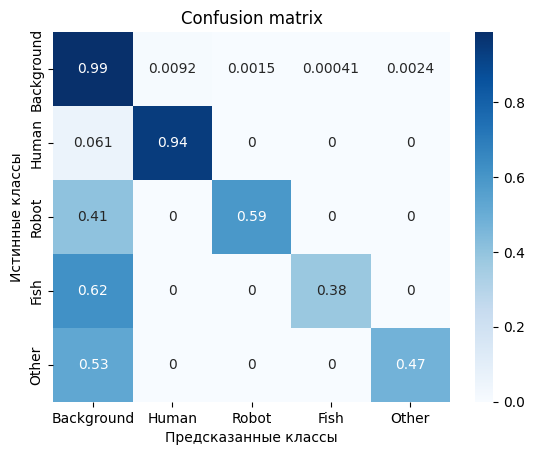

In [32]:
net.eval()

predictions = []
labels = []

accuracies = np.zeros(num_classes)
IoUs = np.zeros(num_classes)

net.eval()
with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.permute(0, 3, 1, 2).to(device)
        labels_batch = labels_batch.permute(0, 3, 1, 2).numpy()
        predict = net(images_batch)
        predict = (
            torch.where(torch.sigmoid(predict) < torch.tensor(0.5), 0.0, 1.0).detach().cpu().numpy()
        )

        for class_index in range(num_classes):
            labels_batch[:, class_index, :, :] = np.where(
                labels_batch[:, class_index, :, :] != 1, 0, class_index + 1
            )
            predict[:, class_index, :, :] = np.where(
                predict[:, class_index, :, :] != 1, 0, class_index + 1
            )

        labels.append(labels_batch)
        predictions.append(predict)

        for class_index in range(num_classes):
            accuracies[class_index] += np.mean(
                predict[:, class_index, :, :] == labels_batch[:, class_index, :, :]
            )
            IoUs[class_index] += IoU_bin(
                labels_batch[:, class_index, :, :], predict[:, class_index, :, :]
            )

    for class_index in range(num_classes):
        accuracies[class_index] /= len(test_loader)
        IoUs[class_index] /= len(test_loader)

    print(f"Accuracy for classes: {accuracies}")
    print(f"IoU for classes: {IoUs}")

    print(f"Accuracy: {np.mean(accuracies):.4f}")
    print(f"IoU: {np.mean(IoUs):.4f}")

    classes_names = ["Background", "Human", "Robot", "Fish", "Other"]
    cm = confusion_matrix(
        np.concatenate(labels, axis=0).flatten(),
        np.concatenate(predictions, axis=0).flatten(),
        labels=np.arange(num_classes),
        normalize="true",
    )
    sea.heatmap(cm, annot=True, cmap="Blues", xticklabels=classes_names, yticklabels=classes_names)
    plt.xlabel("Предсказанные классы")
    plt.ylabel("Истинные классы")
    plt.title("Confusion matrix")
    plt.show()

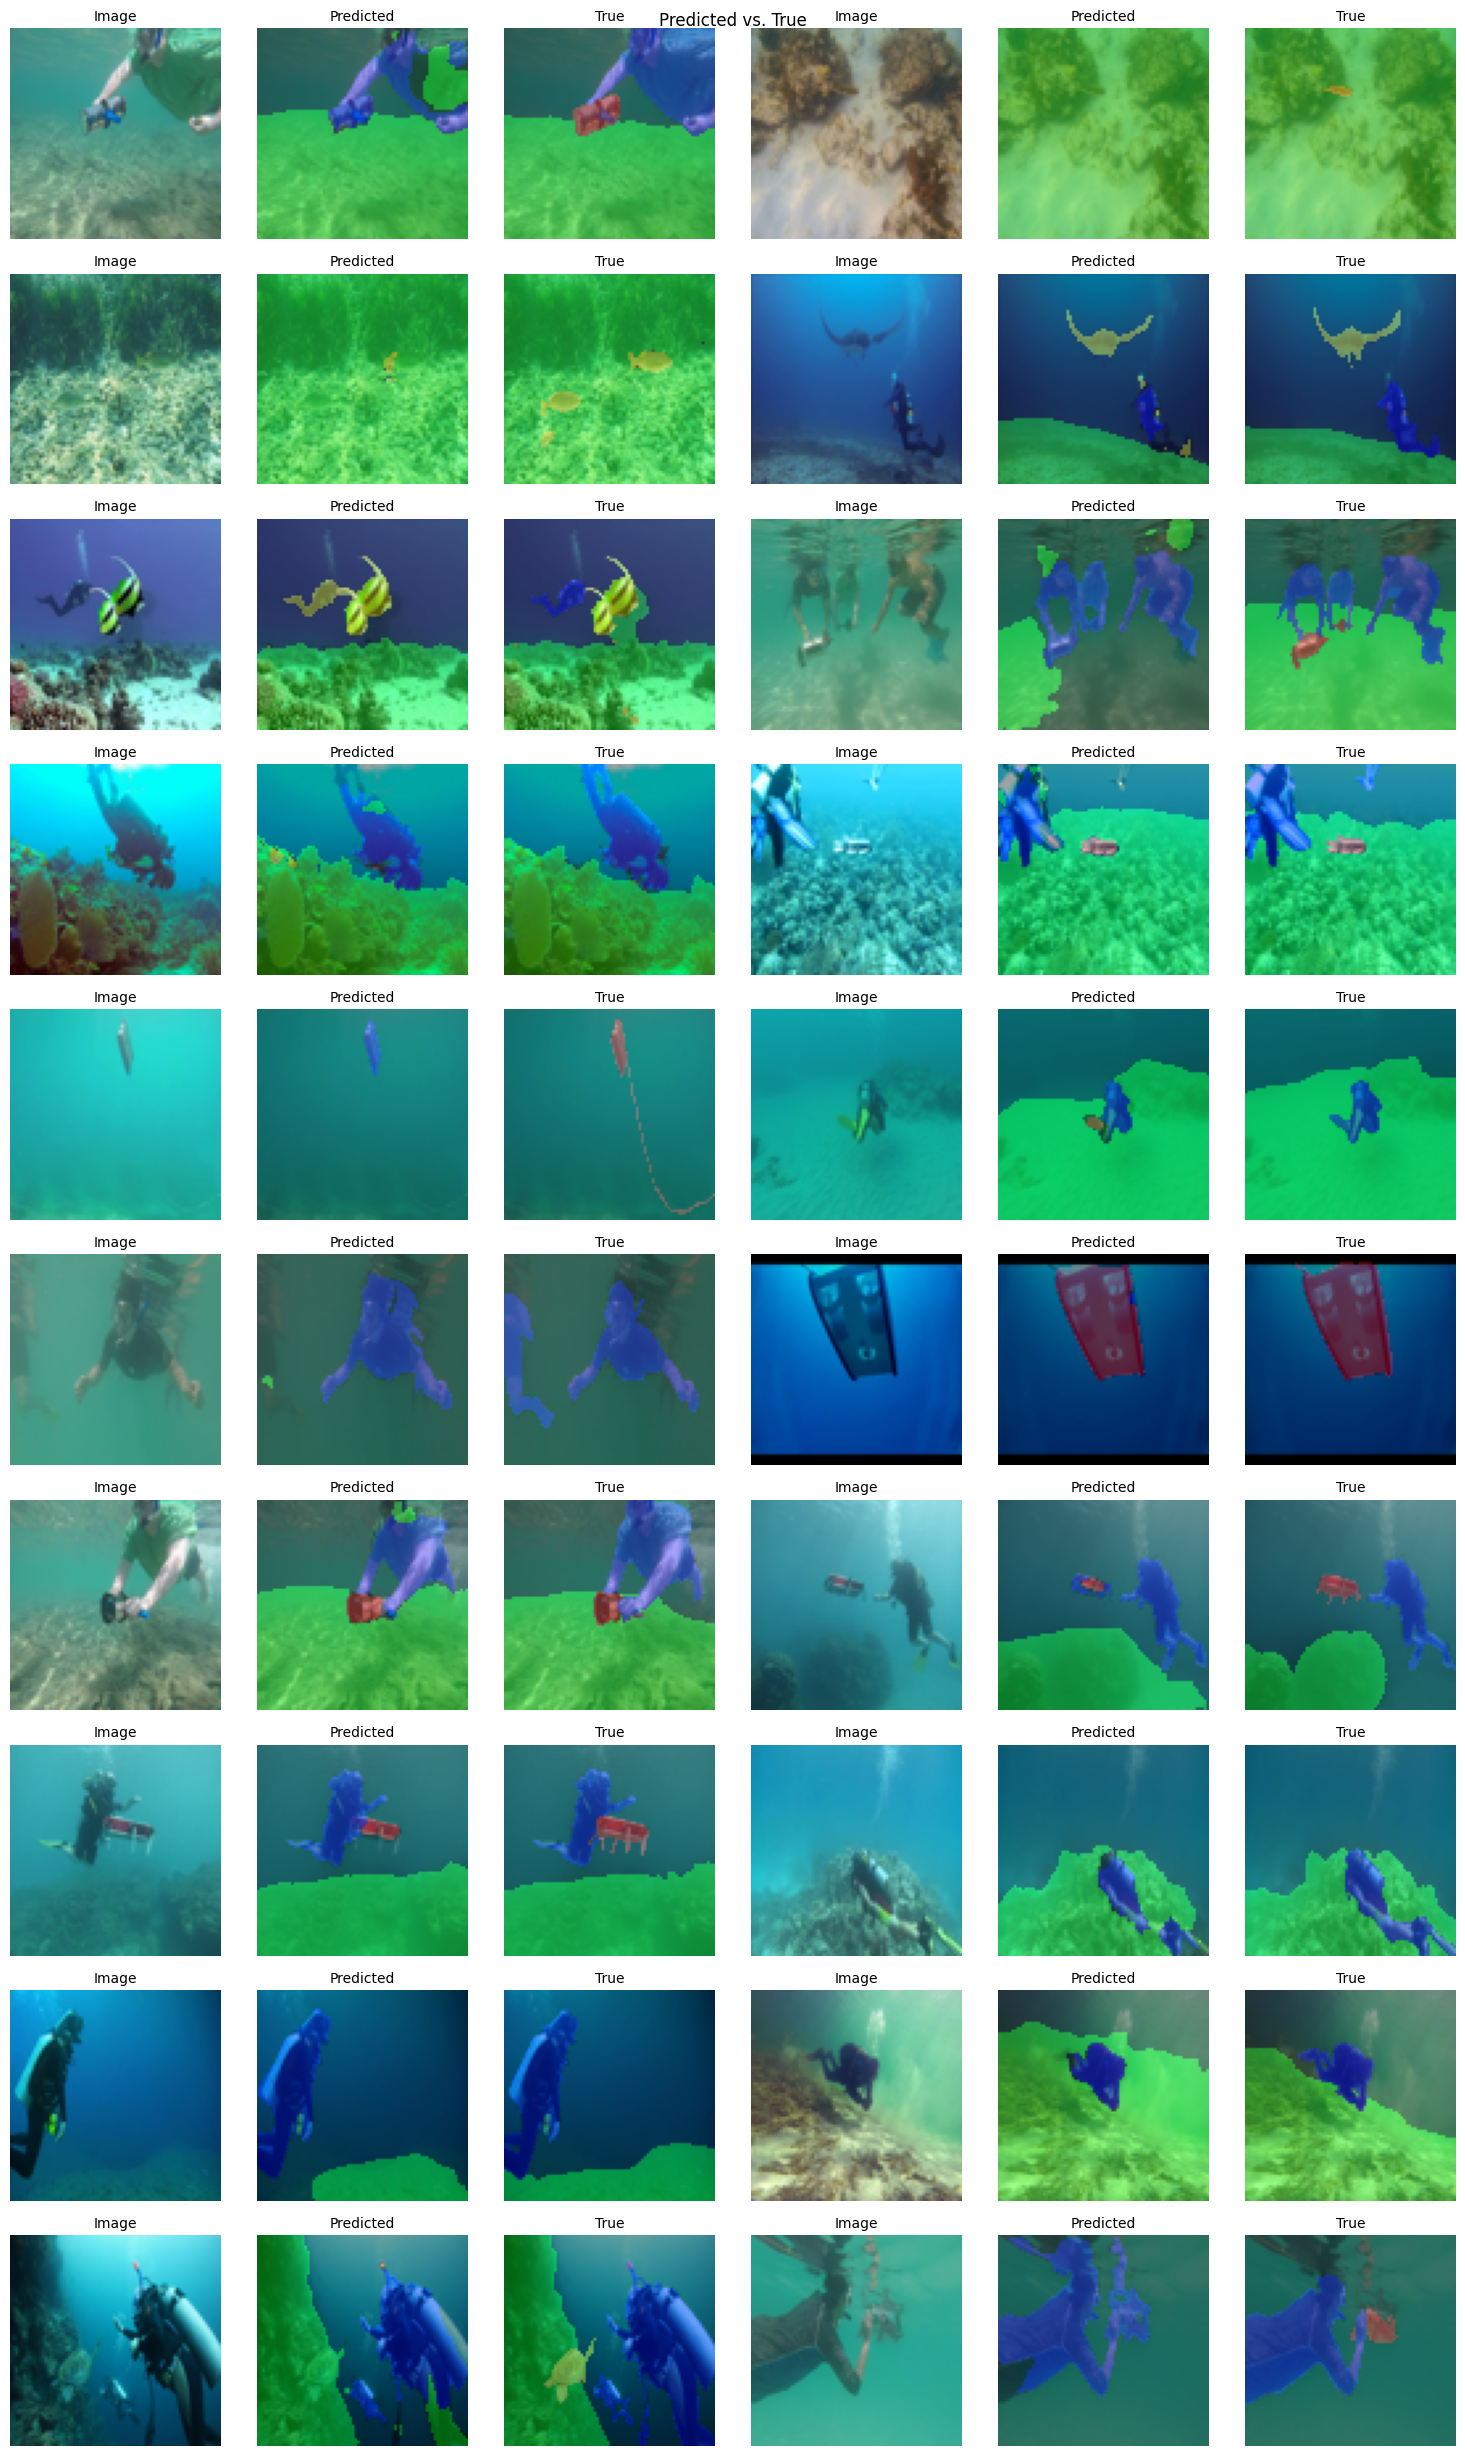

In [33]:
rows = 10
columns = 2
fig, axes = plt.subplots(rows, columns * 3, figsize=(15, 25))
fig.suptitle("Predicted vs. True")

mask_sizes = (*image_size, 3)

for number in range(rows * columns):
    i = number // columns
    j = number % columns

    image, mask = test_dataset[number]

    axes[i, j * 3].imshow(image, cmap=plt.cm.binary)
    axes[i, j * 3].set_title("Image", fontsize=10)
    axes[i, j * 3].axis("off")

    net.eval()
    with torch.no_grad():
        images = image
        images = images.unsqueeze(0)
        images = images.permute(0, 3, 1, 2).to(device)
        predict = net(images)
        predict = (
            torch.where(
                torch.sigmoid(predict) < torch.tensor(0.5),
                torch.tensor(0),
                torch.tensor(1),
            )
            .detach()
            .permute(0, 2, 3, 1)
            .cpu()
        )

    rgb_predicted_mask = np.zeros(mask_sizes)
    for class_index in range(num_classes):
        rgb_predicted_mask[predict[0, :, :, class_index] > 0] = classes_colors[class_index]

    axes[i, j * 3 + 1].imshow(image, cmap=plt.cm.binary)
    axes[i, j * 3 + 1].imshow(rgb_predicted_mask, alpha=0.35)
    axes[i, j * 3 + 1].set_title("Predicted", fontsize=10)
    axes[i, j * 3 + 1].axis("off")

    rgb_mask = np.zeros(mask_sizes)
    for class_index in range(num_classes):
        rgb_mask[mask[:, :, class_index] > 0] = classes_colors[class_index]

    axes[i, j * 3 + 2].imshow(image, cmap=plt.cm.binary)
    axes[i, j * 3 + 2].imshow(rgb_mask, alpha=0.35)
    axes[i, j * 3 + 2].set_title("True", fontsize=10)
    axes[i, j * 3 + 2].axis("off")

plt.tight_layout()
plt.show()